In [17]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import os
import sqlalchemy
from sqlalchemy import create_engine
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.allocation_scenario as asf
import alloc_functions.controller as acf
import alloc_functions.daily as adf
import alloc_functions.cleanup as cleaner
import alloc_functions.mixed as mixed
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import json
from pulp import *
fps_colours = ['#004A9C', '#45D281', '#FEC001','#A365E0', '#5B9BD5',

               '#FF0000', '#0563C1', '#954F72']
import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')


In [8]:
range_wltp = {
    5: 138,
    11: 185,
    33: 166
}
range_real = {vehicle: range_wltp[vehicle]*0.8 for vehicle in range_wltp.keys()}
drive_wltp = {
    5: 0.572463768,
    11: 0.478648649,
    33: 0.40963855
}
payload = {
    5: 765,
    11: 860,
    33: 1002
}
colors = {
    5: fps_colours[4],
    11: fps_colours[3],
    33: fps_colours[5]
}
name = {
    5: "Fiat e-Ducato",
    11: "Maxus eDeliver9",
    33: "Ford e-Transit",
    28: 'Sprinter Diesel'
}
vehicles = [5, 33, 11]
site_name_dict = ff.get_site_name_dict(2)
scenario_dict = {
    201: "normal shifts",
    202: 'all day shifts'
}
scenario_dict_num = {
    201: 1,
    202: 2
}
FPS_COLOURS = ff.FPS_COLOURS

### Scenario table

In [51]:
cnx = dbh.create_alch_engine()
connection, cur = dbh.database_connection('test')
sql_query = f"""SELECT scenario_id, run_id, allocation_id, smart_charging, output_kwh,
    unfeasible_days, breach_days, timeout_days
    FROM t_charging_scenarios WHERE run_id > 190"""
scenarios = pd.read_sql_query(sql_query, con=cnx)
allocation_ids = scenarios['allocation_id'].unique()
sql_query = f"""SELECT allocation_id, site_id, xmpg, charger2, vehicle2,
    num_r, num_vehicle2, num_charger2, source
    FROM t_allocation WHERE allocation_id IN {tuple(allocation_ids)}"""
alloc_summary = pd.read_sql_query(sql_query, cnx)
scenarios = scenarios.merge(alloc_summary, how='left')
scenarios['type'] = scenarios['vehicle2'].map(name)
scenarios['site_name'] = scenarios['site_id'].map(site_name_dict)
scenarios['scenario'] = scenarios['source'].map(scenario_dict)
scenarios['charging_error'] = (
    scenarios[['unfeasible_days', 'breach_days', 'timeout_days']].sum(axis=1)
) > 0
scenarios['site_name'] = scenarios['site_name'] + " " + scenarios['scenario']
scenarios.sort_values(by=['site_name', 'type'], inplace=True)
scenarios.set_index('scenario_id', inplace=True)

cnx.dispose()

In [52]:
# For scenario, caculate allocation_summary
# [feasible, unfeasible_nois, unfeasible_withis, n_duties, n_routes, n_veh]
cols = ['n_feasible', 'n_unfeasible_nois', 'n_duties', 'n_routes', 'n_veh']
alloc_summary.set_index('allocation_id', inplace=True)
alloc_summary = alloc_summary[alloc_summary['vehicle2'] != 28]
feasibility_index = alloc_summary.index
for idx in feasibility_index[:]:
    v = alloc_summary.loc[idx, 'vehicle2']
    print(alloc_summary.loc[idx, ['site_id', 'source', 'vehicle2']].values)
    stats = ff.allocation_summary2(idx, range_real[v], connection, cur)
    alloc_summary.loc[idx, cols] = stats

alloc_summary['feasible_without_pc'] = 100 * alloc_summary['n_feasible'] / alloc_summary['n_duties']
alloc_summary['feasible_with_pc'] = 100 * alloc_summary['n_unfeasible_nois'] / alloc_summary['n_duties']
alloc_summary.sort_values(by='site_id', inplace=True)
alloc_summary.to_csv('sample/argos4/alloc_feasibility.csv')

[311. 201.   5.]
[311. 201.  11.]
[311. 201.  33.]
[309. 201.   5.]
[310. 201.   5.]
[309. 201.  33.]
[284. 202.  33.]
[284. 201.   5.]
[284. 202.   5.]
[310. 202.   5.]
[284. 202.  11.]
[284. 201.  33.]
[308. 202.  33.]
[308. 201.   5.]
[284. 201.  11.]
[308. 201.  11.]
[308. 202.   5.]
[309. 202.   5.]
[310. 201.  11.]
[310. 202.  11.]
[310. 201.  33.]
[309. 202.  33.]
[310. 202.  33.]
[308. 202.  11.]
[309. 202.  11.]
[309. 201.  11.]
[308. 201.  33.]


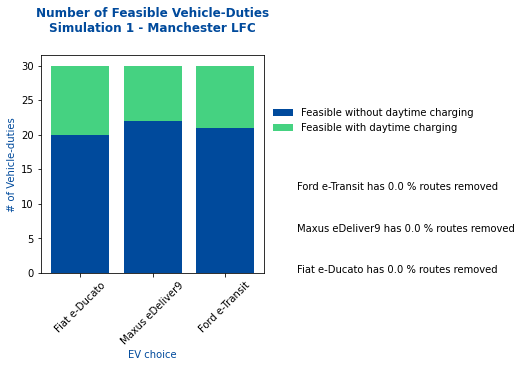

In [15]:
for site in [284, 308, 309, 310]:
    for source in [201, 202]:
# for site in [311]:
#     for source in [201]:
        cols = ['n_feasible', 'n_unfeasible_nois', 'n_routes']
        count_array = alloc_summary[(alloc_summary['site_id'] == site)
                    & (alloc_summary['source'] == source)].sort_values(by='vehicle2')[cols].values
        n_diesel = scenarios.loc[(scenarios['site_id'] == site)
                & (scenarios['source'] == source)
                & (scenarios['vehicle2'] == 28)
                & (scenarios['smart_charging']), 'num_r'].values
        if site == 310:
            n_diesel += 1
        routes_removed = np.round(100 * (n_diesel - count_array[:, 2]) / n_diesel, 1)
        fig, ax = plt.subplots(1, figsize=(4, 4))
        allocated_vehicles = [5, 11, 33]
        xlabels = [name[v] for v in allocated_vehicles]
        ax.bar(x = xlabels,
            height=count_array[:, 0],
            color=[fps_colours[0]], label='Feasible without daytime charging')
        ax.bar(x = xlabels,
            height=count_array[:, 1], bottom=count_array[:, 0],
            color=[fps_colours[1]], label='Feasible with daytime charging')
        ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
        ax.set_xlabel('EV choice', color=fps_colours[0])
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylabel('# of Vehicle-duties', color=fps_colours[0])
        top = (count_array[:, 0]+count_array[:,1]).max()
        for i in range(3):
            ax.text(3, i*0.2*top,
                    f"{xlabels[i]} "
                    f"has {routes_removed[i]} % routes removed")
        ax.set_title(
            f"Number of Feasible Vehicle-Duties"
            f"\nSimulation {scenario_dict_num[source]} - {site_name_dict[site]}",
            color=fps_colours[0], fontweight='bold', y=1.08)
        fig.savefig(
            f"sample/argos4/feasibility_alloc_{site}_{source}.png",
            bbox_inches="tight", dpi=300)

### Load Data check

In [42]:
site_load = pd.read_csv(r'sample\argos4\1900018426509_Croydon_Format.csv',
                        usecols=['datetime', 'kW'], parse_dates=['datetime'], dayfirst=True)

57.029087208289354


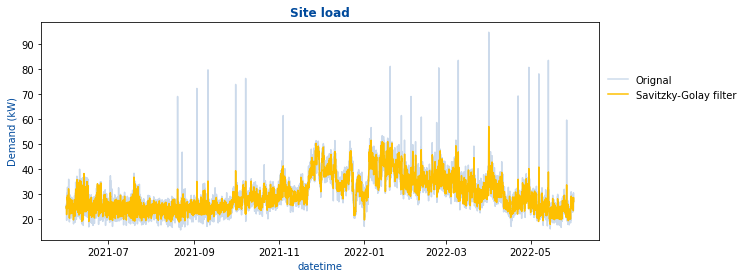

In [75]:
from scipy import signal
filtered_kw = savgol_filter(site_load['kW'], 41, 8)
fig, ax = plt.subplots(
    1, figsize=(10, 4), gridspec_kw={'hspace': 0.5})
ax.set_title(
    'Site load',
    color=fps_colours[0], fontweight='bold')
ax.plot(
    site_load['datetime'],
    site_load['kW'],
    label='Orignal',
    color=fps_colours[0], alpha=0.2)
ax.plot(
    site_load['datetime'],
    filtered_kw,
    label='Savitzky-Golay filter',
    color=fps_colours[2])
# ax.text(1, 0, f"{filtered_kw.max()}")
# ax.set_ylim(top=40)
# ax.set_xticks(xticks)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_ylabel('Demand (kW)', color=fps_colours[0])
ax.set_xlabel('datetime', color=fps_colours[0])
print(filtered_kw.max())

### Shift Starts
This is used to view start times and decide appropiate shift start times

Text(0.5, 0, 'Duration (hours)')

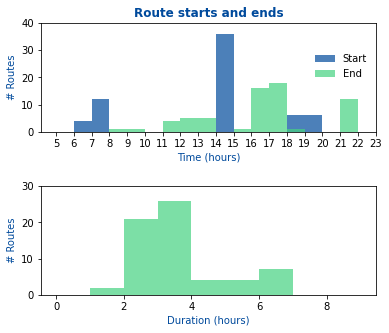

In [66]:
cnx = dbh.create_alch_engine()
site = 310
query = f"SELECT * FROM t_route_master WHERE site_id_start={site} AND source=202"
routes = pd.read_sql_query(query, cnx)
# routes = routes[routes['departure_time'].dt.date == dt.date(2021, 11, 28)]
hour_starts = ((pd.to_datetime(routes['departure_time'])
                -pd.to_datetime(routes['departure_time'].dt.date))
               / np.timedelta64(1, 'h'))
hour_ends = ((pd.to_datetime(routes['arrival_time'])
                -pd.to_datetime(routes['arrival_time'].dt.date))
               / np.timedelta64(1, 'h'))
routes['duration_hours'] = (
    routes['arrival_time'] - routes['departure_time']
    ).dt.total_seconds()/3600
shift_starts = [5, 12, 17]
routes['shift'] = asf.set_shifts(shift_starts, routes)
fig, ax = plt.subplots(
    2, figsize=(6, 5), gridspec_kw={'hspace': 0.5})
ax[0].set_title(
    'Route starts and ends',
    color=fps_colours[0], fontweight='bold')
ax[0].hist(
    hour_starts,
    np.arange(5, 23), label='Start',
    color=[fps_colours[0]], alpha=0.7)
ax[0].hist(
    hour_ends,
    np.arange(5, 23), label='End',
    color=[fps_colours[1]], alpha=0.7)
ax[1].hist(
    routes['duration_hours'],
    np.arange(10), label='End',
    color=[fps_colours[1]], alpha=0.7)
xticks = np.arange(5, 24)
ax[0].set_ylim(top=40)
ax[1].set_ylim(top=30)
ax[0].set_xticks(xticks)
ax[0].legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax[0].set_ylabel('# Routes', color=fps_colours[0])
ax[1].set_ylabel('# Routes', color=fps_colours[0])
ax[0].set_xlabel('Time (hours)', color=fps_colours[0])
ax[1].set_xlabel('Duration (hours)', color=fps_colours[0])

In [80]:
alloc_summary[(alloc_summary['site_id'] == 310)
              & (alloc_summary['vehicle2'] == 11)]

,site_id,xmpg,charger2,vehicle2,num_r,num_vehicle2,num_charger2,source,n_feasible,n_unfeasible_nois,n_duties,n_routes,n_veh,feasible_without_pc,feasible_with_pc
allocation_id,,,,,,,,,,,,,,,
644,310,0.8,50,11,64,27,3,201,10.0,17.0,27.0,64.0,27.0,37.037037,62.962963
662,310,0.8,50,11,64,41,3,202,36.0,5.0,41.0,64.0,41.0,87.804878,12.195122


In [76]:
routes[(routes['departure_time'] >= dt.datetime(2021,9,11,14))
       & (routes['departure_time'] <= dt.datetime(2021,9,11,15))].shape

(36, 15)

### Demand plot

In [3]:
scenarios = [861, 886]
demand_unm = ff.load_charging_profile(scenarios[0])
demand_man = ff.load_charging_profile(scenarios[1])
demand_unm = demand_unm.groupby('datetime').sum()
demand_man = demand_man.groupby('datetime').sum()

In [38]:
def plot_multi_profiles(profiles, start, labels, name, folder):
    try:
        # EV charging
        fig, ax = plt.subplots(
            1, figsize=(6, 4), gridspec_kw={'hspace': 0.4})

        ax.set_title(
            f"{name}\nEV Charging Profiles",
            color=FPS_COLOURS[0], fontweight='bold')
        for i in range(len(profiles)):
            ax.fill_between(
                profiles[i].index,
                profiles[i], 0,
                label=labels[i],
                color=FPS_COLOURS[i], alpha=0.7)
        # ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
        ax.set_ylabel('Power Demand (kVA)', color=FPS_COLOURS[0])
        ax.set_xlabel('Time', color=FPS_COLOURS[0])
        ax.set_xlim(left=start, right=start+dt.timedelta(days=1))
        ax.legend(frameon=False)
        locator = mdates.HourLocator(interval=6)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        fig.savefig(
            f"sample/{folder}/demand_{name}.png",
            bbox_inches="tight", dpi=300)
    except Exception as e:
        logger.error(e)
    return

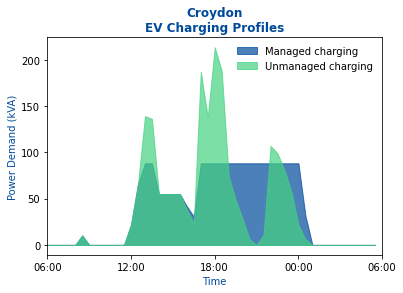

In [40]:
plot_multi_profiles([demand_man['power_demand_kw'], demand_unm['power_demand_kw']],
                       demand_unm.index.min(),
                       ['Managed charging', 'Unmanaged charging'],
                       'Croydon',
                       'argos4')

### Max demand

In [53]:
cols = ['run_id', 'allocation_id', 'vehicle2', 'smart_charging', 'output_kwh', 'type',
        'site_name', 'charging_error']
demand_scenarios = scenarios[(scenarios['vehicle2'] != 30)
                        #      & (scenarios['smart_charging'])
                             ].copy()
# demand_scenarios = scenarios[scenarios['site_id'] == 311].copy()
demand_scenarios[['max_demand', 'max_demand_time', 'mode_time']] = (0, 0, 0)
for idx in demand_scenarios.index:
    if demand_scenarios.loc[idx, 'output_kwh'] > 0:
        demand_scenarios.loc[idx, ['max_demand', 'max_demand_time', 'mode_time']] = ff.find_max_demand(idx)
demand_scenarios['next_demand_kw'] = demand_scenarios['max_demand']/0.9 - 50 * 0.98
demand_scenarios.sort_values(by=['smart_charging', 'run_id', 'site_name'], inplace=True)
# demand_scenarios.to_csv('sample/argos4/scenarios_withcharge.csv')

In [61]:
demand_scenarios['charging_scenario'] = ''
mask_diesel = (demand_scenarios['vehicle2'] == 28) & (demand_scenarios['smart_charging'] == True)
demand_scenarios.loc[mask_diesel, 'charging_scenario'] = 'diesel'
mask_unmanaged = (demand_scenarios['vehicle2'] != 28) & (demand_scenarios['smart_charging'] == False)
demand_scenarios.loc[mask_unmanaged, 'charging_scenario'] = 'unmanaged'
mask_ev = (~demand_scenarios['vehicle2'].isin([5, 28]))
allocations_ev = demand_scenarios.loc[mask_ev, 'allocation_id'].unique()
for allocation_id in allocations_ev:
    mask_valid_scenarios = ((demand_scenarios['allocation_id'] == allocation_id)
                            & ~(demand_scenarios['charging_error']))
    orig_managed_idx = demand_scenarios[mask_valid_scenarios].index.min()
    max_managed_idx = demand_scenarios[mask_valid_scenarios]['max_demand'].idxmin()
    demand_scenarios.loc[orig_managed_idx, 'charging_scenario'] = 'original managed'
    demand_scenarios.loc[max_managed_idx, 'charging_scenario'] = 'max management'
demand_scenarios.to_csv('sample/argos4/scenarios_withcharge.csv')

In [62]:
cols = ['allocation_id', 'smart_charging', 'output_kwh',
       'type', 'site_name', 'max_demand', 'max_demand_time', 'charging_scenario']
demand_scenarios[demand_scenarios['charging_scenario'] != ''][cols].to_csv('sample/argos4/site_demand.csv')

### Count chargers

In [ ]:
scenario = 896
try:
    cnx = dbh.create_alch_engine()
    sql_query = f"""SELECT datetime, power_demand_kw, allocated_vehicle_id FROM t_charge_demand
        WHERE scenario_id={scenario}"""
    demand = pd.read_sql_query(sql_query, con=cnx
                                )
except (Exception, psycopg2.Error) as error:
    logger.error("Error fetching max demand")
    raise error
finally:
    cnx.dispose()
demand['bays_in_use'] = demand['power_demand_kw'] > 0
demand['fast_charge'] = demand['power_demand_kw'] > 22
demand.groupby('datetime')[['bays_in_use', 'fast_charge']].sum().max()